In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

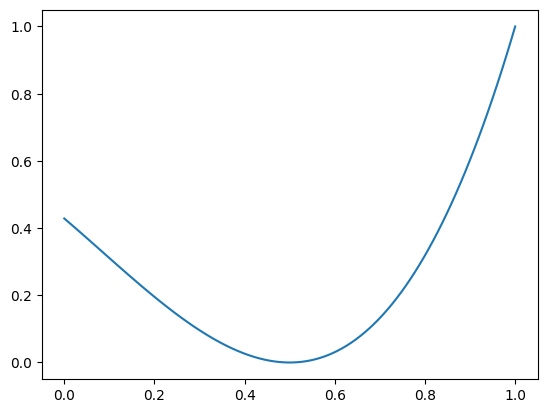

In [36]:
X = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
Y = 2*X**3 - 0.5*X**2 - X + 3
Y = (Y-Y.min())/(Y.max()-Y.min())
plt.plot(X.cpu(), Y.cpu())

In [37]:
class PPOPolicy(nn.Module):
    def __init__(self):
        super(PPOPolicy, self).__init__()
        self.fc_mean = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
        # Predicts the mean of the distribution
        # self.log_std = nn.Parameter(torch.zeros(1))  # Learnable log standard deviation
        self.log_std = nn.Parameter(torch.zeros(1))  # Learnable log standard deviation

    def forward(self, x, action=None):
        mean = self.fc_mean(x)
        std = torch.exp(self.log_std)  # Convert log_std to standard deviation
        distribution = torch.distributions.Normal(mean, std)
        if action is None:
            action = distribution.sample()  # Sample an action
        log_prob = distribution.log_prob(action).sum(dim=-1)  # Compute log probability
        return action, log_prob
    
    def predict(self, x):
        return self.fc_mean(x)


In [41]:
agent = PPOPolicy().to(device)
optimizer = torch.optim.Adam(agent.parameters(), lr=0.001)

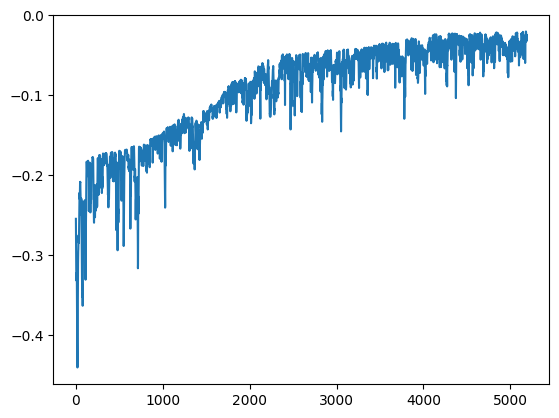

Reward: -0.02470:  52%|█████▏    | 5190/10000 [03:05<02:51, 27.99it/s]


KeyboardInterrupt: 

In [42]:
batch_size = 100
rewards_log = []

tqdm_epochs = tqdm(range(10000))
for epoch in tqdm_epochs:

    states = []
    actions = []
    rewards = []
    log_probs = []

    for _ in tqdm(range(10)):

        perm = torch.randperm(X.size(0))[:20]
        state = X[perm]
        action, log_prob = agent(state)
        reward = (- abs(action - Y[perm])).mean().detach().repeat(state.shape[0])

        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)

    states = torch.concat(states)
    actions = torch.concat(actions)
    log_probs = torch.concat(log_probs)
    rewards = torch.concat(rewards)

    # perm = torch.randperm(states.size(0))
    # states = states[perm]
    # actions = actions[perm]
    # log_probs = log_probs[perm]
    # rewards = rewards[perm]

    # print(states.shape, actions.shape, log_probs.shape, rewards.shape)


    # optimize the model:

    for _ in range(4):

        for i in range(len(states)//batch_size):

            state = states[i*batch_size:(i+1)*batch_size]
            action = actions[i*batch_size:(i+1)*batch_size]
            log_prob = log_probs[i*batch_size:(i+1)*batch_size]
            reward = rewards[i*batch_size:(i+1)*batch_size]

            adv = (reward - reward.mean())/reward.std()

            p_old = log_prob
            p_old = p_old.detach()

            new_action, p_new = agent(state, action)

            ratio = torch.exp(p_new - p_old)
            surr1 = ratio * reward
            surr2 = torch.clamp(ratio, 1 - 0.2, 1 + 0.2) * reward

            # print(ratio.shape, surr1.shape, surr2.shape, reward.shape)

            loss =  - torch.min(surr1, surr2).mean()

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(agent.parameters(), 0.5)
            optimizer.step()
            # break


    # break


    reward = (-abs(agent.predict(X) - Y)).mean().detach()
    rewards_log.append(reward.mean().item())
    tqdm_epochs.set_description(f'Reward: {reward.mean().item():.5f}')

    if epoch % 10 == 0:

        clear_output(True)
        plt.plot(rewards_log)
        plt.show()

        action = agent.predict(X).detach()
        plt.plot(X.cpu(), Y.cpu())
        plt.plot(X.cpu(), action.cpu())
        plt.show()

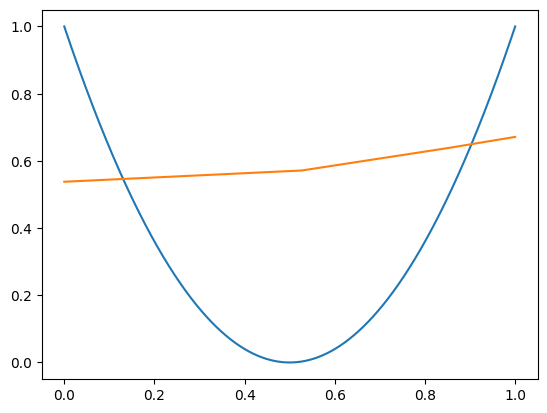

In [ ]:
action = agent.predict(X).detach()
plt.plot(X, Y)
plt.plot(X, action)

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class SimplePolicy(nn.Module):
    def __init__(self):
        super(SimplePolicy, self).__init__()
        self.fc_mean = nn.Sequential(
            nn.Linear(16, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 6)
        )
        
        # Predicts the mean of the distribution
        # self.log_std = nn.Parameter(torch.zeros(1))  # Learnable log standard deviation
        self.log_std = nn.Parameter(torch.zeros(1))  # Learnable log standard deviation

    def forward(self, x, action=None):
        mean = self.fc_mean(x)
        std = torch.exp(self.log_std)  # Convert log_std to standard deviation
        distribution = torch.distributions.Normal(mean, std)
        if action is None:
            action = distribution.sample()  # Sample an action
        log_prob = distribution.log_prob(action).sum(dim=-1)  # Compute log probability
        return action, log_prob
    
    def predict(self, x):
        return self.fc_mean(x)


In [ ]:
class MapAgent(nn.Module):
    def __init__(self, n_anchors):
        super(MapAgent, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, n_anchors)
        )
        
    def forward(self, x):
        return self.network(x)
    
mapper = MapAgent(n_anchors=2)

In [ ]:
N = 256
# meta_agent = MetaAgent([SimplePolicy() for _ in range(N)]).to(device)
meta_agent = SimplePolicy().to(device)

states = torch.rand((N, 16), dtype=torch.float32).to(device)
actions = meta_agent.forward(states)


In [ ]:
for _ in tqdm(range(1000)):
    actions = meta_agent.get_actions(x)

  0%|          | 0/1000 [00:00<?, ?it/s]


AttributeError: 'SimplePolicy' object has no attribute 'get_actions'

In [ ]:
alphas = torch.rand((1000))

for alpha in tqdm(alphas):

    agent3 = SimplePolicy()
    for p1, p2, p3 in zip(agent1.parameters(), agent2.parameters(), agent3.parameters()):
        
        x1 = p1.data.unsqueeze(-1)
        x2 = p2.data.unsqueeze(-1)
        x_alpha = alpha.repeat(x1.size())
        model_input = torch.concat((x1, x2, x_alpha), dim=-1)
        with torch.no_grad():
            x3 = mapper(model_input)
        p3.data = x3

100%|██████████| 1000/1000 [00:00<00:00, 4214.16it/s]


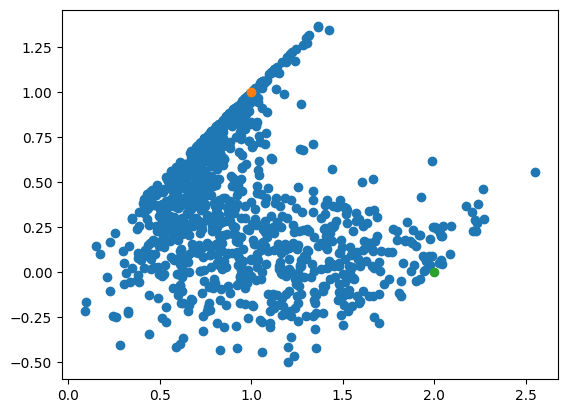

In [ ]:
w1 = np.array([1, 1])
w2 = np.array([2, 0])

wz = []
for _ in range(1000):
    u = np.random.uniform(0, 1)
    z = (1-u)**2*w1 + u**2*w2 + np.random.normal(0, 0.2)
    wz.append(z)

wz = np.array(wz)

plt.scatter(wz[:, 0], wz[:, 1])
plt.scatter(w1[0], w1[1])
plt.scatter(w2[0], w2[1])